In [74]:
%cd /content/drive/MyDrive/varnita/nlp

/content/drive/MyDrive/varnita/nlp


In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow import keras 
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPool1D,GlobalAveragePooling1D,SpatialDropout1D
from keras.models import Sequential
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [76]:
df_train= pd.read_csv("data/train.csv",encoding='latin1')
df_test= pd.read_csv("data/test.csv",encoding='latin1')
df_new=pd.concat([df_train,df_test])

#**First 10 rows**

In [77]:
df_new.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative


#**Last 10 rows**

In [78]:
df_new.tail(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
3788,3789,48741,Pakistan,16-03-2020,You never eaten the pigs cat dog or food from ...,Neutral
3789,3790,48742,"California, USA",16-03-2020,@calebmealer @thebradfordfile @realDonaldTrump...,Extremely Positive
3790,3791,48743,"Cincinnati, Ohio",16-03-2020,"Even though the Law Library is closed, ALL sub...",Positive
3791,3792,48744,Washington D.C.,16-03-2020,"With Gov Hogan's announcement that all bars, r...",Extremely Negative
3792,3793,48745,Washington D.C.,16-03-2020,"@RicePolitics @MDCounties Craig, will you call...",Negative
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative
3797,3798,48750,"Arlington, Virginia",16-03-2020,I and @ForestandPaper members are committed to...,Extremely Positive


#**Information about data**

In [79]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44955 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


#**Number of missing values in data**

In [80]:
df_new.isnull().sum()

UserName            0
ScreenName          0
Location         9424
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

#**Number of duplicate values in data**

In [81]:
df_new.duplicated().sum()

0

#**Number of unique values in columns**

In [82]:
df_new_1=df_new.drop(["ScreenName","OriginalTweet"],axis=1)
for x in df_new_1.columns:
      print(x ,':', len(df_new_1[x].unique()))

UserName : 44955
Location : 13128
TweetAt : 44
Sentiment : 5


#**Count of unique values for the column Sentiment**

In [83]:
print(df_new["Sentiment"].value_counts().sort_values(ascending=False))

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64


#**Places of missing values in data**

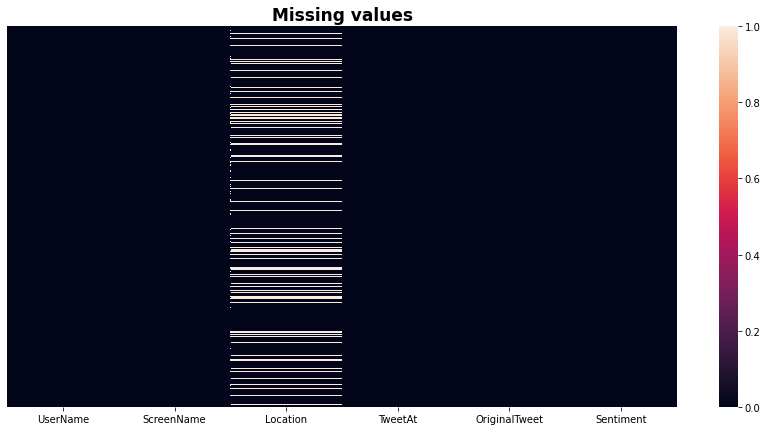

In [84]:
plt.figure(figsize=(15,7))
sns.heatmap(df_new.isnull(), cbar=True, yticklabels=False)
plt.title("Missing values",fontweight="bold",size=17)
plt.show()

#**Barplot for the top 20 places with most tweets**

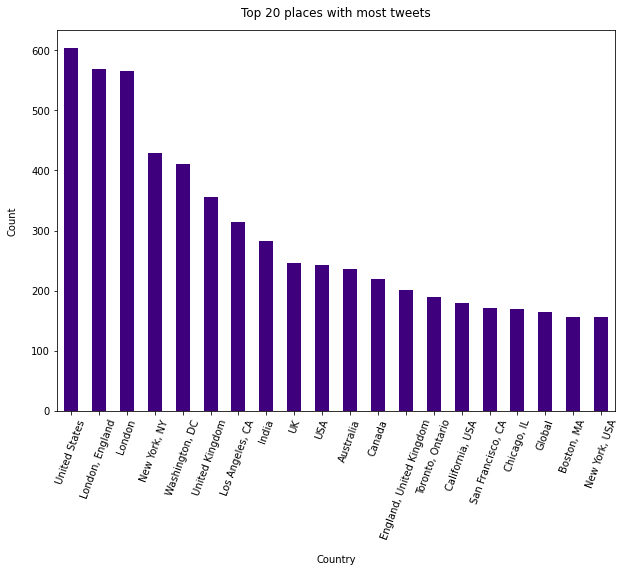

In [85]:
df_new['Location'].value_counts().sort_values(ascending=False).head(20).plot(kind='bar',figsize=(10,7), rot=70,colormap='Purples_r');
plt.xlabel("Country", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Top 20 places with most tweets", y=1.02);

#**Percentage distribution of tweets from top 20 locations** 

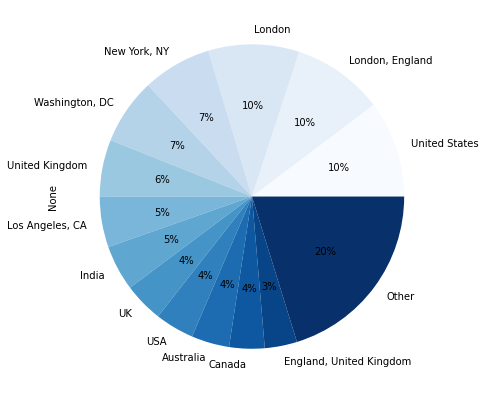

In [86]:
# Most of the locations are the same but with a different name. It would be interesting to combine these places with tweets.
Counts=df_new['Location'].value_counts().sort_values(ascending=False).head(20)
Counts_others=Counts[Counts<200]
Counts_top=Counts[Counts>=200]
small_sums = pd.Series([Counts_others.sum()], index=["Other"])
Counts_top=Counts_top.append(small_sums)
Counts_top.plot(kind='pie',figsize=(10,7),colormap='Blues',autopct='%1.0f%%',y='Location');

#**Countplot for different classes**

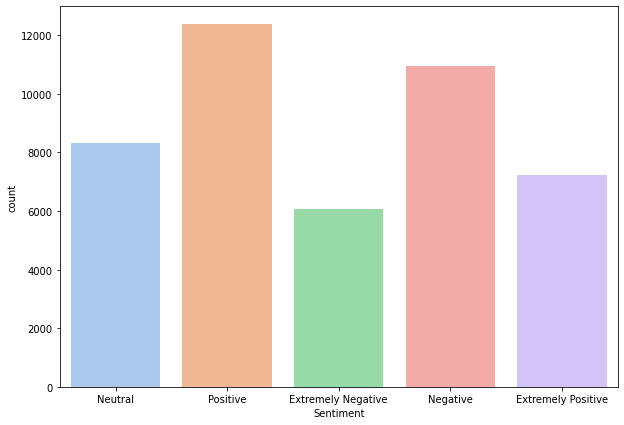

In [87]:
plt.figure(figsize=(10,7))
sns.countplot(data= df_new,x='Sentiment',palette='pastel')
plt.show()

#**Countplot for tweets on different dates**

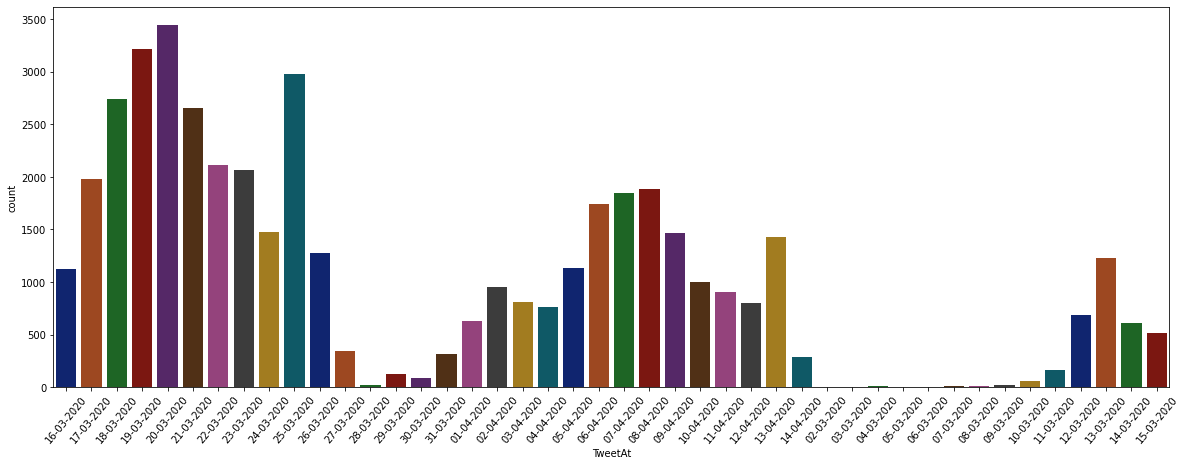

In [88]:
plt.figure(figsize=(20,7))
chart=sns.countplot(data= df_new,x='TweetAt',palette='dark')
chart.set_xticklabels(chart.get_xticklabels(), rotation=50)
plt.show()

#**Merging five classes into three prominent classes**

In [89]:
def sentiments(x):
    if (x ==  "Extremely Positive" or x== "Positive"):
        return "Positive"
    elif (x == "Extremely Negative" or x == "Negative"):
        return "Negative"
    else:
        return "Neutral"
    
df_new['Sentiment']=df_new['Sentiment'].apply(lambda x:sentiments(x))
df_train['Sentiment']=df_train['Sentiment'].apply(lambda x: sentiments(x))
df_test['Sentiment']=df_test['Sentiment'].apply(lambda x: sentiments(x))
print(df_new["Sentiment"].value_counts().sort_values(ascending=False))

Positive    19592
Negative    17031
Neutral      8332
Name: Sentiment, dtype: int64


#**Percentage distribution of the classes after merging**

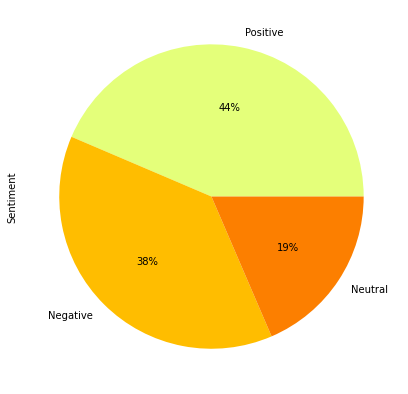

In [90]:
df_new['Sentiment'].value_counts().plot(kind='pie',figsize=(10,7),colormap='Wistia',autopct='%1.0f%%');

#**Countplot for different classes of tweets on different days**

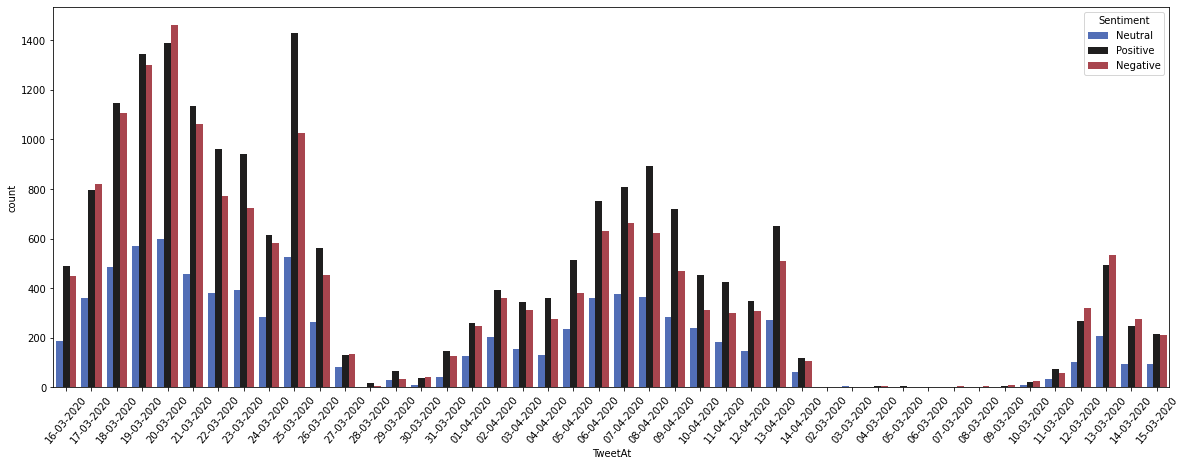

In [91]:
plt.figure(figsize=(20,7))
chart=sns.countplot(data= df_new,x='TweetAt',hue='Sentiment',palette='icefire')
chart.set_xticklabels(chart.get_xticklabels(), rotation=50)
plt.show()

In [92]:
df_train = df_train.drop(['Location','TweetAt','ScreenName','UserName',], axis=1)
df_test = df_test.drop(['Location','TweetAt','ScreenName','UserName'], axis=1)
df_new_2 = pd.concat([df_train,df_test])

#**Removing all links,mentions and special characters**

In [96]:
removables = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def clean(x):
  x = re.sub(removables, ' ', str(x).lower()).strip()
  return x

In [97]:
df_train.OriginalTweet = df_train.OriginalTweet.apply(lambda x:clean (x))
df_test.OriginalTweet = df_test.OriginalTweet.apply(lambda x:clean (x))
df_new_2.OriginalTweet = df_new_2.OriginalTweet.apply(lambda x:clean (x))

In [98]:
df_train['OriginalTweet'].head(5)

0                          phil gahan chrisitv and and
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
Name: OriginalTweet, dtype: object

#**Removing stop words**

In [99]:
stop = stopwords.words('english')
df_train.OriginalTweet = df_train.OriginalTweet.apply(lambda x:' '.join([word for word in x.split() if word not in (stop)]))
df_test.OriginalTweet = df_test.OriginalTweet.apply(lambda x:' '.join([word for word in x.split() if word not in (stop)]))
df_new_2.OriginalTweet = df_new_2.OriginalTweet.apply(lambda x:' '.join([word for word in x.split() if word not in (stop)]))

In [100]:
df_train['OriginalTweet'].head(5)

0                                  phil gahan chrisitv
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
3    food stock one empty please panic enough food ...
4    ready go supermarket covid19 outbreak paranoid...
Name: OriginalTweet, dtype: object

#**Generating wordcloud to see the most frequent words for each class**

In [101]:
def cloud(x,s):
  wordcloud = WordCloud(width=800, height=800, random_state=15, max_font_size=110).generate(x)
  plt.figure(figsize=(15,15))
  plt.title(s)
  plt.imshow(wordcloud,interpolation = 'bilinear')

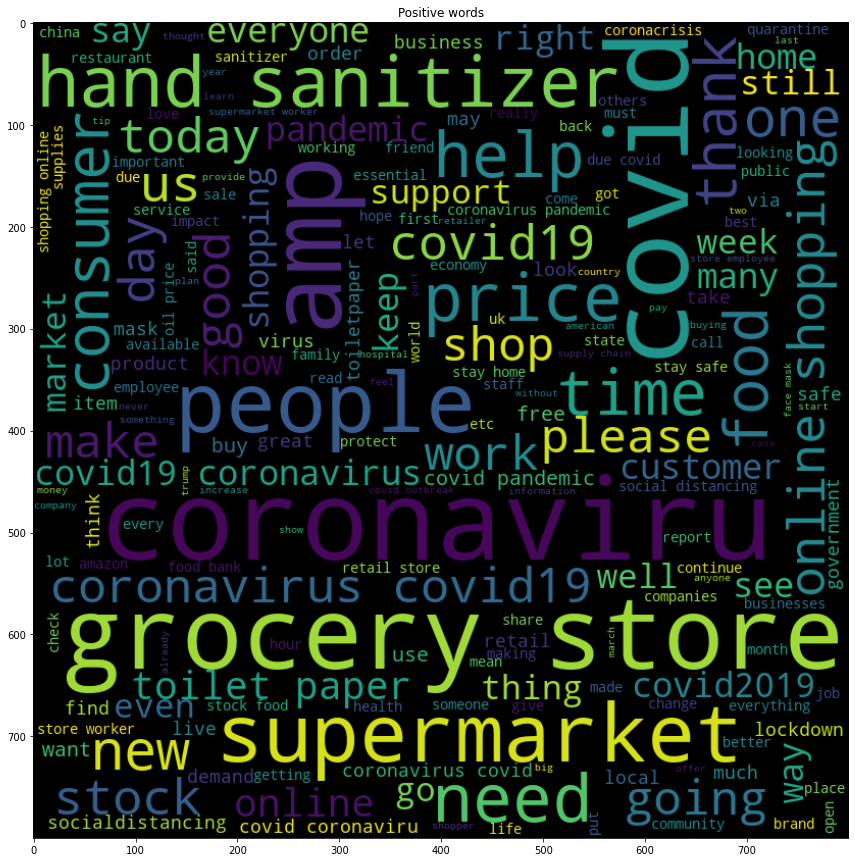

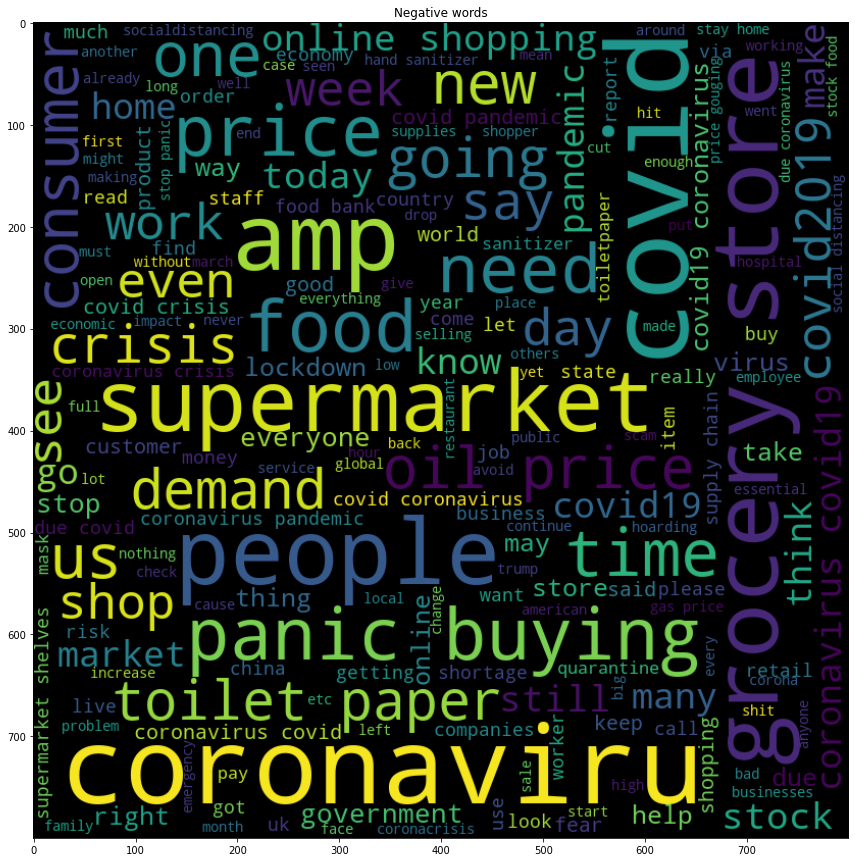

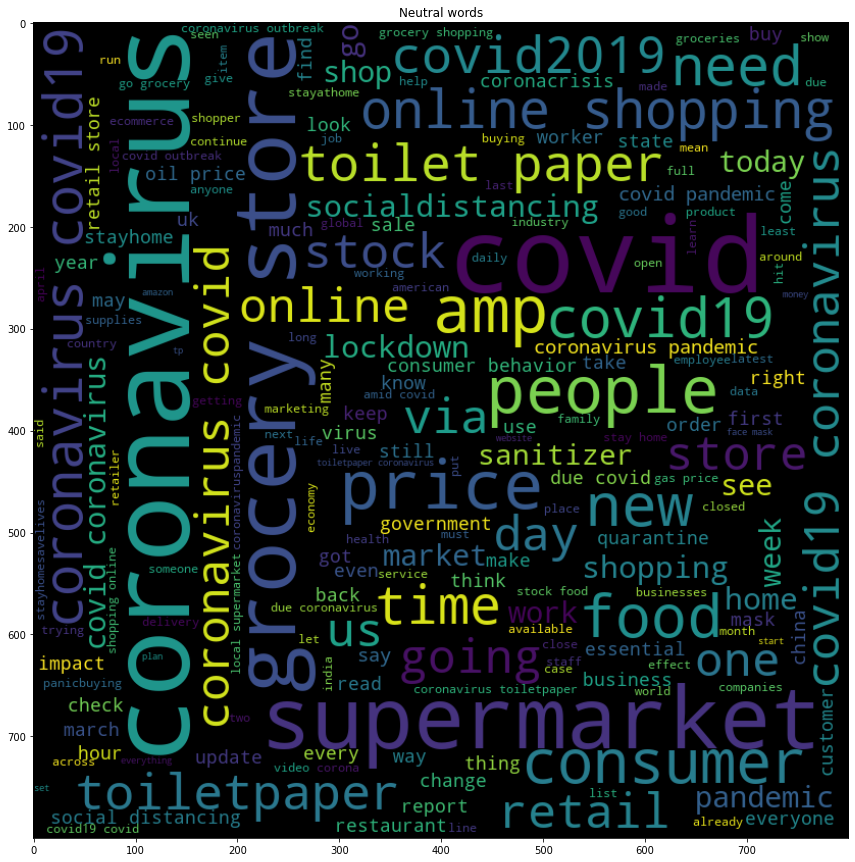

In [102]:
Positive= ' '.join([text for text in df_new_2['OriginalTweet'][df_new_2['Sentiment'] == 'Positive']])
cloud(Positive,'Positive words')
Negative= ' '.join([text for text in df_new_2['OriginalTweet'][df_new_2['Sentiment'] == 'Negative']])
cloud(Negative,'Negative words')
Neutral= ' '.join([text for text in df_new_2['OriginalTweet'][df_new_2['Sentiment'] == 'Neutral']])
cloud(Neutral,'Neutral words')

#**Lemmatizing the data**

In [103]:
lemmatizer = nltk.stem.WordNetLemmatizer()
df_train.OriginalTweet = df_train.OriginalTweet.apply(lambda x:" ".join([lemmatizer.lemmatize(word) for word in x.split()]))
df_test.OriginalTweet = df_test.OriginalTweet.apply(lambda x:" ".join([lemmatizer.lemmatize(word) for word in x.split()]))
df_new_2.OriginalTweet = df_new_2.OriginalTweet.apply(lambda x:" ".join([lemmatizer.lemmatize(word) for word in x.split()]))

In [104]:
df_train['OriginalTweet']

0                                      phil gahan chrisitv
1        advice talk neighbour family exchange phone nu...
2        coronavirus australia woolworth give elderly d...
3        food stock one empty please panic enough food ...
4        ready go supermarket covid19 outbreak paranoid...
                               ...                        
41152    airline pilot offering stock supermarket shelf...
41153    response complaint provided citing covid 19 re...
41154    know getting tough kameronwilds rationing toil...
41155    wrong smell hand sanitizer starting turn coron...
41156    well new used rift going 700 00 amazon rn alth...
Name: OriginalTweet, Length: 41157, dtype: object

#**Tokenizing the text**

In [105]:
token = Tokenizer()
token.fit_on_texts(df_train.OriginalTweet)
word_index = token.word_index
vocab_size = len(token.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 48817


#**Replacing each word with its corresponding integer value from the word_index and padding it to make the data equal in length**

In [106]:
train_data=token.texts_to_sequences(df_train.OriginalTweet)
test_data=token.texts_to_sequences(df_test.OriginalTweet)
maxlen = 200
x_train = pad_sequences(train_data, maxlen= maxlen, padding='pre', value=0)
x_test = pad_sequences(test_data, maxlen = maxlen, padding='pre', value=0)
x_train

array([[    0,     0,     0, ...,  6298, 20350, 14330],
       [    0,     0,     0, ...,   964,  2186,   102],
       [    0,     0,     0, ...,     3,     2,    75],
       ...,
       [    0,     0,     0, ..., 48814,    29,    18],
       [    0,     0,     0, ...,     1,    12,     1],
       [    0,     0,     0, ...,     3,     2, 48816]], dtype=int32)

#**One hot encoding the classes**

In [107]:
y_train= pd.get_dummies(df_train.Sentiment)
y_test= pd.get_dummies(df_test.Sentiment)
y_train

,Negative,Neutral,Positive
0,0,1,0
1,0,0,1
2,0,0,1
3,0,0,1
4,1,0,0
...,...,...,...
41152,0,1,0
41153,1,0,0
41154,0,0,1
41155,0,1,0


#**Getting embeddings from GloVe model for our data**

In [37]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [108]:
embeddings_index = {}
f = open('glove.6B.200d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [109]:
embedding_matrix = np.zeros((len(word_index) + 1, maxlen))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [40]:
embedding_layer = tf.keras.layers.Embedding(input_dim=len(word_index) + 1,
                            output_dim=200,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False)

In [110]:
callbacks = [
     keras.callbacks.ModelCheckpoint(
         filepath="/content/drive/MyDrive/varnita/nlp/model/4",
         save_best_only=True,  # Only save a model if `val_loss` has improved.
         monitor="val_loss",
         verbose=1,
     ),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.0000001),
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        restore_best_weights=True,
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=30,
        verbose=1,
    )]

#**Model**

In [54]:
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(80,activation='tanh',return_sequences='True')))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.2))
model.add(Dense(53, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 9.3e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(x_train, y_train, epochs=200, batch_size=34,validation_split=0.2,callbacks=callbacks,workers=2 )

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          9763400   
                                                                 
 bidirectional_9 (Bidirectio  (None, 200, 160)         179840    
 nal)                                                            
                                                                 
 global_max_pooling1d_6 (Glo  (None, 160)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_15 (Dropout)        (None, 160)               0         
                                                                 
 dense_19 (Dense)            (None, 53)                8533      
                                                                 
 dropout_16 (Dropout)        (None, 53)               

INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


969/969 [==============================] - 36s 34ms/step - loss: 0.5555 - accuracy: 0.5545 - val_loss: 0.4899 - val_accuracy: 0.6446 - lr: 9.3000e-05
Epoch 2/200
969/969 [==============================] - ETA: 0s - loss: 0.4846 - accuracy: 0.6544
Epoch 00002: val_loss improved from 0.48986 to 0.45988, saving model to /content/drive/MyDrive/varnita/nlp/model/4


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


969/969 [==============================] - 31s 32ms/step - loss: 0.4846 - accuracy: 0.6544 - val_loss: 0.4599 - val_accuracy: 0.6710 - lr: 9.3000e-05
Epoch 3/200
969/969 [==============================] - ETA: 0s - loss: 0.4580 - accuracy: 0.6825
Epoch 00003: val_loss improved from 0.45988 to 0.44061, saving model to /content/drive/MyDrive/varnita/nlp/model/4


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


969/969 [==============================] - 33s 34ms/step - loss: 0.4580 - accuracy: 0.6825 - val_loss: 0.4406 - val_accuracy: 0.6942 - lr: 9.3000e-05
Epoch 4/200
969/969 [==============================] - ETA: 0s - loss: 0.4402 - accuracy: 0.6976
Epoch 00004: val_loss improved from 0.44061 to 0.42501, saving model to /content/drive/MyDrive/varnita/nlp/model/4


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


969/969 [==============================] - 32s 33ms/step - loss: 0.4402 - accuracy: 0.6976 - val_loss: 0.4250 - val_accuracy: 0.7094 - lr: 9.3000e-05
Epoch 5/200
969/969 [==============================] - ETA: 0s - loss: 0.4260 - accuracy: 0.7113
Epoch 00005: val_loss improved from 0.42501 to 0.41415, saving model to /content/drive/MyDrive/varnita/nlp/model/4


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


969/969 [==============================] - 31s 32ms/step - loss: 0.4260 - accuracy: 0.7113 - val_loss: 0.4142 - val_accuracy: 0.7182 - lr: 9.3000e-05
Epoch 6/200
968/969 [============================>.] - ETA: 0s - loss: 0.4129 - accuracy: 0.7233
Epoch 00006: val_loss improved from 0.41415 to 0.40556, saving model to /content/drive/MyDrive/varnita/nlp/model/4


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


969/969 [==============================] - 32s 33ms/step - loss: 0.4129 - accuracy: 0.7233 - val_loss: 0.4056 - val_accuracy: 0.7268 - lr: 9.3000e-05
Epoch 7/200
969/969 [==============================] - ETA: 0s - loss: 0.4046 - accuracy: 0.7309
Epoch 00007: val_loss improved from 0.40556 to 0.40107, saving model to /content/drive/MyDrive/varnita/nlp/model/4


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


969/969 [==============================] - 32s 33ms/step - loss: 0.4046 - accuracy: 0.7309 - val_loss: 0.4011 - val_accuracy: 0.7276 - lr: 9.3000e-05
Epoch 8/200
967/969 [============================>.] - ETA: 0s - loss: 0.3926 - accuracy: 0.7412
Epoch 00008: val_loss improved from 0.40107 to 0.39497, saving model to /content/drive/MyDrive/varnita/nlp/model/4


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


969/969 [==============================] - 32s 33ms/step - loss: 0.3925 - accuracy: 0.7413 - val_loss: 0.3950 - val_accuracy: 0.7346 - lr: 9.3000e-05
Epoch 9/200
968/969 [============================>.] - ETA: 0s - loss: 0.3839 - accuracy: 0.7491
Epoch 00009: val_loss improved from 0.39497 to 0.38765, saving model to /content/drive/MyDrive/varnita/nlp/model/4


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


969/969 [==============================] - 31s 32ms/step - loss: 0.3839 - accuracy: 0.7491 - val_loss: 0.3877 - val_accuracy: 0.7386 - lr: 9.3000e-05
Epoch 10/200
968/969 [============================>.] - ETA: 0s - loss: 0.3750 - accuracy: 0.7569
Epoch 00010: val_loss improved from 0.38765 to 0.38452, saving model to /content/drive/MyDrive/varnita/nlp/model/4


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


969/969 [==============================] - 33s 34ms/step - loss: 0.3749 - accuracy: 0.7569 - val_loss: 0.3845 - val_accuracy: 0.7447 - lr: 9.3000e-05
Epoch 11/200
967/969 [============================>.] - ETA: 0s - loss: 0.3648 - accuracy: 0.7671
Epoch 00011: val_loss improved from 0.38452 to 0.37927, saving model to /content/drive/MyDrive/varnita/nlp/model/4


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


969/969 [==============================] - 32s 33ms/step - loss: 0.3648 - accuracy: 0.7671 - val_loss: 0.3793 - val_accuracy: 0.7417 - lr: 9.3000e-05
Epoch 12/200
969/969 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.7746
Epoch 00012: val_loss improved from 0.37927 to 0.37551, saving model to /content/drive/MyDrive/varnita/nlp/model/4


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


969/969 [==============================] - 32s 33ms/step - loss: 0.3560 - accuracy: 0.7746 - val_loss: 0.3755 - val_accuracy: 0.7522 - lr: 9.3000e-05
Epoch 13/200
967/969 [============================>.] - ETA: 0s - loss: 0.3479 - accuracy: 0.7787
Epoch 00013: val_loss improved from 0.37551 to 0.37438, saving model to /content/drive/MyDrive/varnita/nlp/model/4


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


969/969 [==============================] - 32s 33ms/step - loss: 0.3480 - accuracy: 0.7787 - val_loss: 0.3744 - val_accuracy: 0.7443 - lr: 9.3000e-05
Epoch 14/200
969/969 [==============================] - ETA: 0s - loss: 0.3392 - accuracy: 0.7870
Epoch 00014: val_loss did not improve from 0.37438
969/969 [==============================] - 20s 21ms/step - loss: 0.3392 - accuracy: 0.7870 - val_loss: 0.3804 - val_accuracy: 0.7491 - lr: 9.3000e-05
Epoch 15/200
967/969 [============================>.] - ETA: 0s - loss: 0.3315 - accuracy: 0.7917
Epoch 00015: val_loss improved from 0.37438 to 0.36621, saving model to /content/drive/MyDrive/varnita/nlp/model/4


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


969/969 [==============================] - 32s 33ms/step - loss: 0.3315 - accuracy: 0.7917 - val_loss: 0.3662 - val_accuracy: 0.7552 - lr: 9.3000e-05
Epoch 16/200
968/969 [============================>.] - ETA: 0s - loss: 0.3233 - accuracy: 0.7997
Epoch 00016: val_loss did not improve from 0.36621
969/969 [==============================] - 20s 21ms/step - loss: 0.3233 - accuracy: 0.7997 - val_loss: 0.3796 - val_accuracy: 0.7526 - lr: 9.3000e-05
Epoch 17/200
967/969 [============================>.] - ETA: 0s - loss: 0.3170 - accuracy: 0.8027
Epoch 00017: val_loss improved from 0.36621 to 0.36175, saving model to /content/drive/MyDrive/varnita/nlp/model/4


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


969/969 [==============================] - 32s 33ms/step - loss: 0.3172 - accuracy: 0.8026 - val_loss: 0.3617 - val_accuracy: 0.7653 - lr: 9.3000e-05
Epoch 18/200
967/969 [============================>.] - ETA: 0s - loss: 0.3092 - accuracy: 0.8111
Epoch 00018: val_loss did not improve from 0.36175
969/969 [==============================] - 20s 21ms/step - loss: 0.3092 - accuracy: 0.8111 - val_loss: 0.4089 - val_accuracy: 0.7279 - lr: 9.3000e-05
Epoch 19/200
969/969 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.8149
Epoch 00019: val_loss did not improve from 0.36175
969/969 [==============================] - 20s 20ms/step - loss: 0.3021 - accuracy: 0.8149 - val_loss: 0.3717 - val_accuracy: 0.7556 - lr: 9.3000e-05
Epoch 20/200
967/969 [============================>.] - ETA: 0s - loss: 0.2931 - accuracy: 0.8234
Epoch 00020: val_loss improved from 0.36175 to 0.35269, saving model to /content/drive/MyDrive/varnita/nlp/model/4


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/varnita/nlp/model/4/assets


969/969 [==============================] - 31s 32ms/step - loss: 0.2931 - accuracy: 0.8235 - val_loss: 0.3527 - val_accuracy: 0.7680 - lr: 9.3000e-05
Epoch 21/200
968/969 [============================>.] - ETA: 0s - loss: 0.2885 - accuracy: 0.8268
Epoch 00021: val_loss did not improve from 0.35269
969/969 [==============================] - 20s 21ms/step - loss: 0.2886 - accuracy: 0.8267 - val_loss: 0.4083 - val_accuracy: 0.7462 - lr: 9.3000e-05
Epoch 22/200
967/969 [============================>.] - ETA: 0s - loss: 0.2818 - accuracy: 0.8300
Epoch 00022: val_loss did not improve from 0.35269
969/969 [==============================] - 20s 21ms/step - loss: 0.2819 - accuracy: 0.8299 - val_loss: 0.3562 - val_accuracy: 0.7700 - lr: 9.3000e-05
Epoch 23/200
967/969 [============================>.] - ETA: 0s - loss: 0.2761 - accuracy: 0.8346
Epoch 00023: val_loss did not improve from 0.35269
969/969 [==============================] - 20s 20ms/step - loss: 0.2761 - accuracy: 0.8346 - val_loss: 

#**Making classifications for test data**

In [61]:
model = keras.models.load_model('/content/drive/MyDrive/varnita/nlp/model/4')
pred=np.round(model.predict(x_test))

#**Visualizing results**

Accuracy: 0.8001579778830964
              precision    recall  f1-score   support

    Negative       0.83      0.79      0.81      1633
     Neutral       0.77      0.71      0.74       619
    Positive       0.78      0.85      0.82      1546

   micro avg       0.80      0.80      0.80      3798
   macro avg       0.79      0.78      0.79      3798
weighted avg       0.80      0.80      0.80      3798
 samples avg       0.80      0.80      0.80      3798



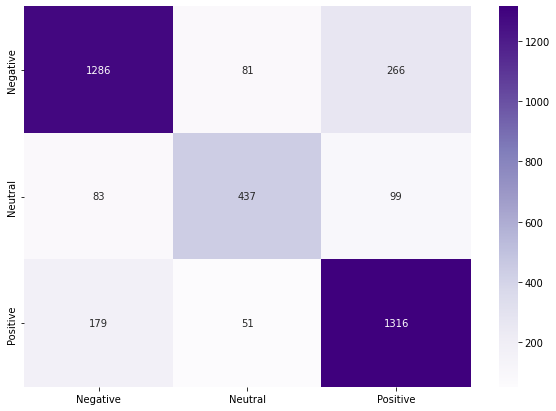

In [73]:
cm=confusion_matrix(y_test.values.argmax(axis=1), pred.argmax(axis=1))
xlabel=['Negative', 'Neutral','Positive']
ylabel=['Negative', 'Neutral','Positive']
plt.figure(figsize = (10,7))
sns.heatmap(cm, cmap="Purples", annot=True,fmt='g',xticklabels=xlabel,yticklabels=ylabel)
accuracy=accuracy_score(y_test, pred)
print('Accuracy:' ,accuracy)
target_names = ['Negative', 'Neutral','Positive']
print(classification_report(y_test, pred, target_names= target_names))